In [1]:
# Reference: https://amaru-ai.com/entry/2022/10/15/202442

# データの読込
まずは対象のデータをダウンロードします。

In [2]:
# !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
# !unzip NewsAggregatorDataset.zip
# !rm NewsAggregatorDataset.zip

In [3]:
# 行数の確認
!wc -l ./newsCorpora.csv

422937 ../../../../datasets/nlp/classification/newsCorpora.csv


In [4]:
# 先頭10行の確認
!head -5 ./newsCorpora.csv

1	Fed official says weak data caused by weather, should not slow taper	http://www.latimes.com/business/money/la-fi-mo-federal-reserve-plosser-stimulus-economy-20140310,0,1312750.story\?track=rss	Los Angeles Times	b	ddUyU0VZz0BRneMioxUPQVP6sIxvM	www.latimes.com	1394470370698
2	Fed's Charles Plosser sees high bar for change in pace of tapering	http://www.livemint.com/Politics/H2EvwJSK2VE6OF7iK1g3PP/Feds-Charles-Plosser-sees-high-bar-for-change-in-pace-of-ta.html	Livemint	b	ddUyU0VZz0BRneMioxUPQVP6sIxvM	www.livemint.com	1394470371207
3	US open: Stocks fall after Fed official hints at accelerated tapering	http://www.ifamagazine.com/news/us-open-stocks-fall-after-fed-official-hints-at-accelerated-tapering-294436	IFA Magazine	b	ddUyU0VZz0BRneMioxUPQVP6sIxvM	www.ifamagazine.com	1394470371550
4	Fed risks falling 'behind the curve', Charles Plosser says	http://www.ifamagazine.com/news/fed-risks-falling-behind-the-curve-charles-plosser-says-294430	IFA Magazine	b	ddUyU0VZz0BRneMioxUPQVP6sIxvM	www

In [5]:
# 読込時のエラー回避のためダブルクォーテーションをシングルクォーテーションに置換
!sed -e 's/"/'\''/g' ./newsCorpora.csv > ./newsCorpora_re.csv

In [6]:
# 続いて、データフレームとして読込み、情報源（PUBLISHER）がReuters, Huffington Post, Businessweek, Contactmusic.com, Daily Mailの事例のみを抽出した後、学習データ、検証データ、評価データに分割しておきます。

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split

# データの読込
df = pd.read_csv('./newsCorpora_re.csv',
                 header=None,
                 sep='\t', 
                 names=['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP'])

# データの抽出
df = df.loc[df['PUBLISHER'].isin(['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']), ['TITLE', 'CATEGORY']]

# データの分割
train, valid_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=123, stratify=df['CATEGORY'])
valid, test = train_test_split(valid_test, test_size=0.5, shuffle=True, random_state=123, stratify=valid_test['CATEGORY'])
train.reset_index(drop=True, inplace=True)
valid.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

print(train.head())

                                               TITLE CATEGORY
0  REFILE-UPDATE 1-European car sales up for sixt...        b
1  Amazon Plans to Fight FTC Over Mobile-App Purc...        t
2  Kids Still Get Codeine In Emergency Rooms Desp...        m
3  What On Earth Happened Between Solange And Jay...        e
4  NATO Missile Defense Is Flight Tested Over Hawaii        b


In [8]:
# 事例数の確認
# (b: ビジネス、e: エンターテインメント、t: 科学技術、m: 健康)
print('【学習データ】')
print(train['CATEGORY'].value_counts())
print('【検証データ】')
print(valid['CATEGORY'].value_counts())
print('【評価データ】')
print(test['CATEGORY'].value_counts())

【学習データ】
b    4501
e    4235
t    1220
m     728
Name: CATEGORY, dtype: int64
【検証データ】
b    563
e    529
t    153
m     91
Name: CATEGORY, dtype: int64
【評価データ】
b    563
e    530
t    152
m     91
Name: CATEGORY, dtype: int64


## 学習の準備

BERTモデルを利用するためにtransformersライブラリをインストールしておきます。transformersを通じて、BERT以外にも多くの事前学習済みモデルを短いコードで非常に簡単に利用することができます。

In [9]:
import numpy as np
import transformers
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from torch import optim
from torch import cuda
import time
from matplotlib import pyplot as plt

/home/yuki/.pyenv/versions/3.10.7/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-12-19 16:44:30.928250: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-19 16:44:31.538763: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-19 16:44:31.538843: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plu

In [10]:
# 次に、データをモデルに投入可能な形に整形します。

# まずは、PyTorchでよく利用される、特徴ベクトルとラベルベクトルを合わせて保持するDatasetを作成するためのクラスを定義します。
# このクラスにtokenizerを渡すことで、入力テキストの前処理を行い、指定した最長系列長までパディングした上で単語IDに変換する処理を実現できるようにしておきます。
# とはいえ、BERT用にすべての処理が書かれたtokenizerそのものは、のちほどtranformersを通じて取得するため、クラス内で必要なものはtokenizerに渡す処理と結果を受け取る処理のみです。

In [11]:
# Datasetの定義
class NewsDataset(Dataset):
  def __init__(self, X, y, tokenizer, max_len):
    self.X = X
    self.y = y
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):  # len(Dataset)で返す値を指定
    return len(self.y)

  def __getitem__(self, index):  # Dataset[index]で返す値を指定
    text = self.X[index]
    inputs = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_len,
      pad_to_max_length=True
    )
    ids = inputs['input_ids']
    mask = inputs['attention_mask']

    return {
      'ids': torch.LongTensor(ids),
      'mask': torch.LongTensor(mask),
      'labels': torch.Tensor(self.y[index])
    }

In [12]:
# 上記を用いてDatasetを作成します。

# なお、英語版事前学習済みモデルとして利用できるBERTは、最高精度を目指した構成であるLARGEと、それよりパラメータの少ないBASE、
# それらのそれぞれについて小文字のみ（Uncased）と大文字小文字混在（Cased）の4パターンがあります。
# 今回は、手軽に試すことができるBASEのUncasedを使っていきます。

In [13]:
# 正解ラベルのone-hot化
y_train = pd.get_dummies(train, columns=['CATEGORY'])[['CATEGORY_b', 'CATEGORY_e', 'CATEGORY_t', 'CATEGORY_m']].values
y_valid = pd.get_dummies(valid, columns=['CATEGORY'])[['CATEGORY_b', 'CATEGORY_e', 'CATEGORY_t', 'CATEGORY_m']].values
y_test = pd.get_dummies(test, columns=['CATEGORY'])[['CATEGORY_b', 'CATEGORY_e', 'CATEGORY_t', 'CATEGORY_m']].values

# Datasetの作成
max_len = 20
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
dataset_train = NewsDataset(train['TITLE'], y_train, tokenizer, max_len)
dataset_valid = NewsDataset(valid['TITLE'], y_valid, tokenizer, max_len)
dataset_test = NewsDataset(test['TITLE'], y_test, tokenizer, max_len)

for var in dataset_train[0]:
  print(f'{var}: {dataset_train[0][var]}')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


ids: tensor([  101, 25416,  9463,  1011, 10651,  1015,  1011,  2647,  2482,  4341,
         2039,  2005,  4369,  3204,  2004, 18730,  8980,   102,     0,     0])
mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0])
labels: tensor([1., 0., 0., 0.])


/home/yuki/.pyenv/versions/3.10.7/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [14]:
# 1文目の文の情報を出力しています。

# 入力文字列がidsとしてID系列に変換されていることが確認できます。
# BERTでは、変換の過程で元の文の文頭と文末に特殊区切り文字である[CLS]と[SEP]がそれぞれ挿入されるため、それらも101と102として系列に含まれています。0はパディングを表します。
# 正解ラベルもlabelsとしてone-hot形式で保持しています。

# また、パディングの位置を表すmaskも合わせて保持し、学習時にidsと一緒にモデルに渡せるようにしておきます。

# 続いて、ネットワークを定義します。 transfomersを用いることで、BERT部分はまるごとBertModelで表現可能です。
# その後、分類タスクに対応するため、BERTの出力ベクトルを受け取るドロップアウトと全結合層を定義すれば完成です。

In [15]:
# BERT分類モデルの定義
class BERTClass(torch.nn.Module):
  def __init__(self, drop_rate, otuput_size):
    super().__init__()
    self.bert = BertModel.from_pretrained('bert-base-uncased')
    self.drop = torch.nn.Dropout(drop_rate)
    self.fc = torch.nn.Linear(768, otuput_size)  # BERTの出力に合わせて768次元を指定
    
  def forward(self, ids, mask):
    _, out = self.bert(ids, attention_mask=mask, return_dict=False)
    out = self.fc(self.drop(out))
    return out

## BERT分類モデルの学習

ここまでで、Datasetとネットワークが準備できたため、あとは普段通りの学習ループを作成します。 ここでは一連の流れをtrain_model関数として定義しています。

登場する構成要素の意味については、[【言語処理100本ノック 2020】第8章: ニューラルネット](https://amaru-ai.com/entry/2022/10/14/204710)の記事の中で、問題の流れに沿って解説していますので、そちらをご参照ください。

In [16]:
def calculate_loss_and_accuracy(model, criterion, loader, device):
  """ 損失・正解率を計算"""
  model.eval()
  loss = 0.0
  total = 0
  correct = 0
  with torch.no_grad():
    for data in loader:
      # デバイスの指定
      ids = data['ids'].to(device)
      mask = data['mask'].to(device)
      labels = data['labels'].to(device)

      # 順伝播
      outputs = model(ids, mask)

      # 損失計算
      loss += criterion(outputs, labels).item()

      # 正解率計算
      pred = torch.argmax(outputs, dim=-1).cpu().numpy() # バッチサイズの長さの予測ラベル配列
      labels = torch.argmax(labels, dim=-1).cpu().numpy()  # バッチサイズの長さの正解ラベル配列
      total += len(labels)
      correct += (pred == labels).sum().item()
      
  return loss / len(loader), correct / total
  

def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, device=None):
  """モデルの学習を実行し、損失・正解率のログを返す"""
  # デバイスの指定
  model.to(device)

  # dataloaderの作成
  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
  dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)

  # 学習
  log_train = []
  log_valid = []
  for epoch in range(num_epochs):
    # 開始時刻の記録
    s_time = time.time()

    # 訓練モードに設定
    model.train()
    for data in dataloader_train:
      # デバイスの指定
      ids = data['ids'].to(device)
      mask = data['mask'].to(device)
      labels = data['labels'].to(device)

      # 勾配をゼロで初期化
      optimizer.zero_grad()

      # 順伝播 + 誤差逆伝播 + 重み更新
      outputs = model(ids, mask)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      
    # 損失と正解率の算出
    loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train, device)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid, device)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    # チェックポイントの保存
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

    # 終了時刻の記録
    e_time = time.time()

    # ログを出力
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec') 

  return {'train': log_train, 'valid': log_valid}

In [17]:
# パラメータを設定して、ファインチューニングを実行します。

In [18]:
# パラメータの設定
DROP_RATE = 0.4
OUTPUT_SIZE = 4
BATCH_SIZE = 32
NUM_EPOCHS = 4
LEARNING_RATE = 2e-5

# モデルの定義
model = BERTClass(DROP_RATE, OUTPUT_SIZE)

# 損失関数の定義
criterion = torch.nn.BCEWithLogitsLoss()

# オプティマイザの定義
optimizer = torch.optim.AdamW(params=model.parameters(), lr=LEARNING_RATE)

# デバイスの指定
device = 'cuda' if cuda.is_available() else 'cpu'

# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, device=device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


epoch: 1, loss_train: 0.0904, accuracy_train: 0.9516, loss_valid: 0.1274, accuracy_valid: 0.9184, 23.8498sec
epoch: 2, loss_train: 0.0421, accuracy_train: 0.9801, loss_valid: 0.0940, accuracy_valid: 0.9371, 23.4795sec
epoch: 3, loss_train: 0.0276, accuracy_train: 0.9883, loss_valid: 0.0999, accuracy_valid: 0.9274, 23.3509sec
epoch: 4, loss_train: 0.0206, accuracy_train: 0.9921, loss_valid: 0.1188, accuracy_valid: 0.9237, 23.5849sec


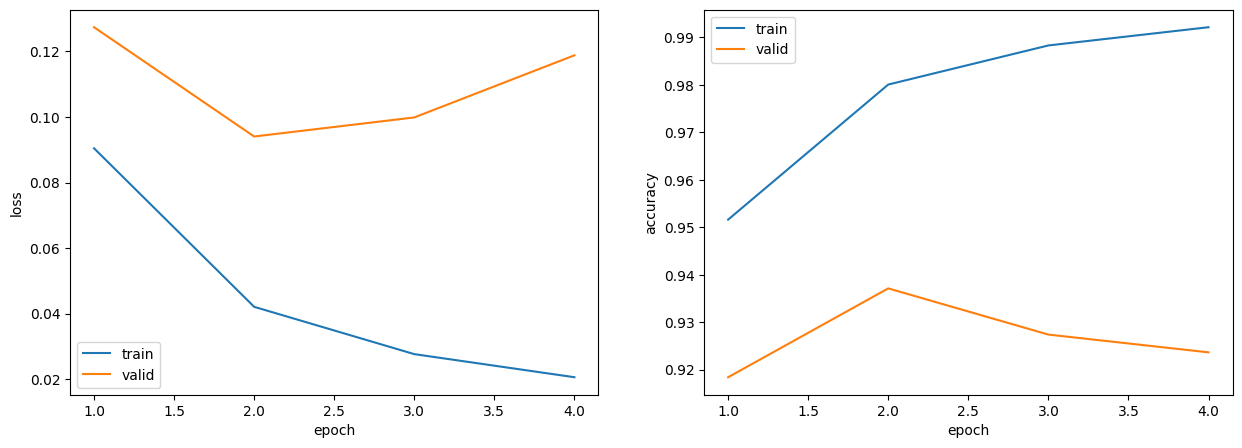

In [19]:
# ログの可視化
x_axis = [x for x in range(1, len(log['train']) + 1)]
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(x_axis, np.array(log['train']).T[0], label='train')
ax[0].plot(x_axis, np.array(log['valid']).T[0], label='valid')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[1].plot(x_axis, np.array(log['train']).T[1], label='train')
ax[1].plot(x_axis, np.array(log['valid']).T[1], label='valid')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()
plt.show()

In [20]:
# 正解率の算出
def calculate_accuracy(model, dataset, device):
  # Dataloaderの作成
  loader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)

  model.eval()
  total = 0
  correct = 0
  with torch.no_grad():
    for data in loader:
      # デバイスの指定
      ids = data['ids'].to(device)
      mask = data['mask'].to(device)
      labels = data['labels'].to(device)

      # 順伝播 + 予測値の取得 + 正解数のカウント
      outputs = model.forward(ids, mask)
      pred = torch.argmax(outputs, dim=-1).cpu().numpy()
      labels = torch.argmax(labels, dim=-1).cpu().numpy()
      total += len(labels)
      correct += (pred == labels).sum().item()

  return correct / total

print(f'正解率（学習データ）：{calculate_accuracy(model, dataset_train, device):.3f}')
print(f'正解率（検証データ）：{calculate_accuracy(model, dataset_valid, device):.3f}')
print(f'正解率（評価データ）：{calculate_accuracy(model, dataset_test, device):.3f}')

正解率（学習データ）：0.992
正解率（検証データ）：0.924
正解率（評価データ）：0.930
